Available columns: ['Unnamed: 0', 'AAPL', 'AAPL.1', 'AAPL.2', 'AAPL.3', 'AAPL.4']
Using AAPL and AAPL.1


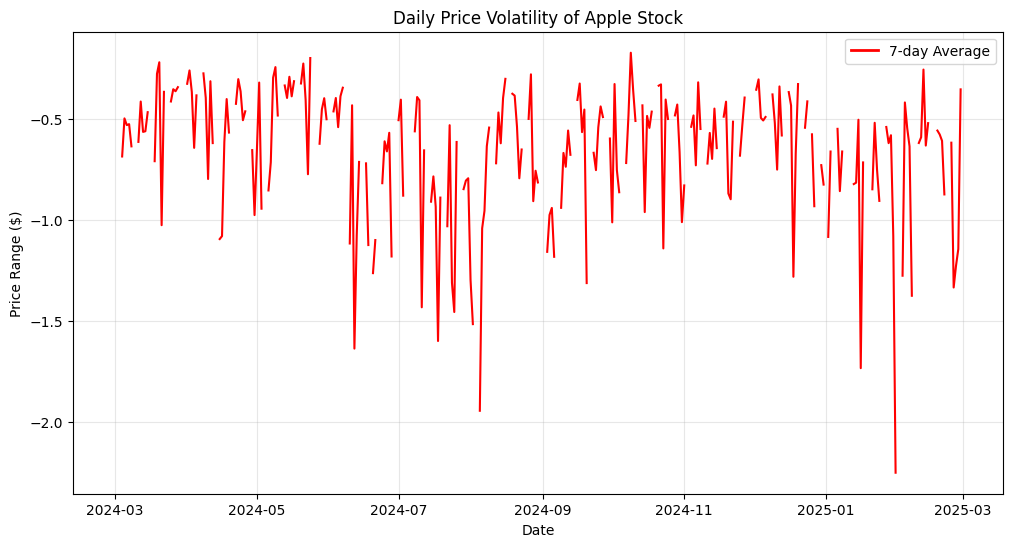

Average daily volatility: $-0.66
Maximum daily volatility: $-0.17 on 2024-10-09


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('apple_stock_1year_1h.csv', skiprows=1)

print("Available columns:", df.columns.tolist())

date_column = df.columns[0]
df['Datetime'] = pd.to_datetime(df[date_column])
df = df.set_index('Datetime')


high_variants = ['high', 'High', 'HIGH']
low_variants = ['low', 'Low', 'LOW']

high_col = None
for col in high_variants:
    if col in df.columns:
        high_col = col
        break

low_col = None
for col in low_variants:
    if col in df.columns:
        low_col = col
        break

if high_col and low_col:
    print(f"Using {high_col} and {low_col} for volatility calculation")
    df['Volatility'] = df[high_col] - df[low_col]
else:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Using {numeric_cols[0]} and {numeric_cols[1]}")
    df['Volatility'] = df[numeric_cols[0]] - df[numeric_cols[1]]

daily_volatility = df['Volatility'].resample('D').mean()


plt.figure(figsize=(12, 6))


plt.plot(daily_volatility.index, daily_volatility.values, color='red')


plt.plot(daily_volatility.index, daily_volatility.rolling(window=7).mean(), 
         color='red', linewidth=2, label='7-day Average')


plt.xlabel('Date')
plt.ylabel('Price Range ($)')
plt.title('Daily Price Volatility of Apple Stock')
plt.grid(True, alpha=0.3)
plt.legend()


plt.show()


print(f"Average daily volatility: ${daily_volatility.mean():.2f}")
print(f"Maximum daily volatility: ${daily_volatility.max():.2f} on {daily_volatility.idxmax().strftime('%Y-%m-%d')}")


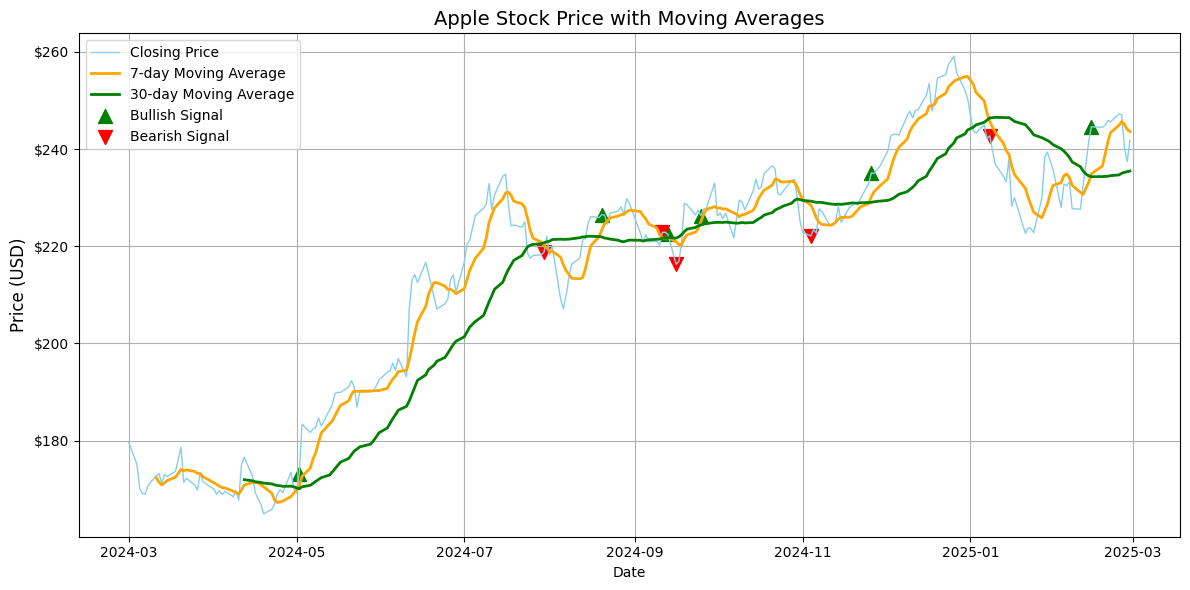

Bullish signals (short MA crosses above long MA):
- 2024-05-02
- 2024-08-20
- 2024-09-13
- 2024-09-25
- 2024-11-26
- 2025-02-14

Bearish signals (short MA crosses below long MA):
- 2024-07-30
- 2024-09-11
- 2024-09-16
- 2024-11-04
- 2025-01-08


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('apple_stock_1year_1h.csv')

df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

daily_data = df['Close'].resample('D').last().dropna()

ma_short = daily_data.rolling(window=7).mean() 
ma_long = daily_data.rolling(window=30).mean()  

plt.figure(figsize=(12, 6))

plt.subplots_adjust(left=0.15)

plt.plot(daily_data.index, daily_data, label='Closing Price', color='skyblue', linewidth=1)
plt.plot(ma_short.index, ma_short, label='7-day Moving Average', color='orange', linewidth=2)
plt.plot(ma_long.index, ma_long, label='30-day Moving Average', color='green', linewidth=2)

bullish = (ma_short > ma_long) & (ma_short.shift(1) <= ma_long.shift(1))  
bearish = (ma_short < ma_long) & (ma_short.shift(1) >= ma_long.shift(1))  


plt.scatter(daily_data.index[bullish], daily_data[bullish], color='green', s=100, 
            marker='^', label='Bullish Signal')
plt.scatter(daily_data.index[bearish], daily_data[bearish], color='red', s=100, 
            marker='v', label='Bearish Signal')


from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))


plt.xlabel('Date')
plt.ylabel('Price (USD)', fontsize=12)
plt.title('Apple Stock Price with Moving Averages', fontsize=14)
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


bullish_dates = daily_data.index[bullish].strftime('%Y-%m-%d').tolist()
bearish_dates = daily_data.index[bearish].strftime('%Y-%m-%d').tolist()

print("Bullish signals (short MA crosses above long MA):")
for date in bullish_dates:
    print(f"- {date}")

print("\nBearish signals (short MA crosses below long MA):")
for date in bearish_dates:
    print(f"- {date}")


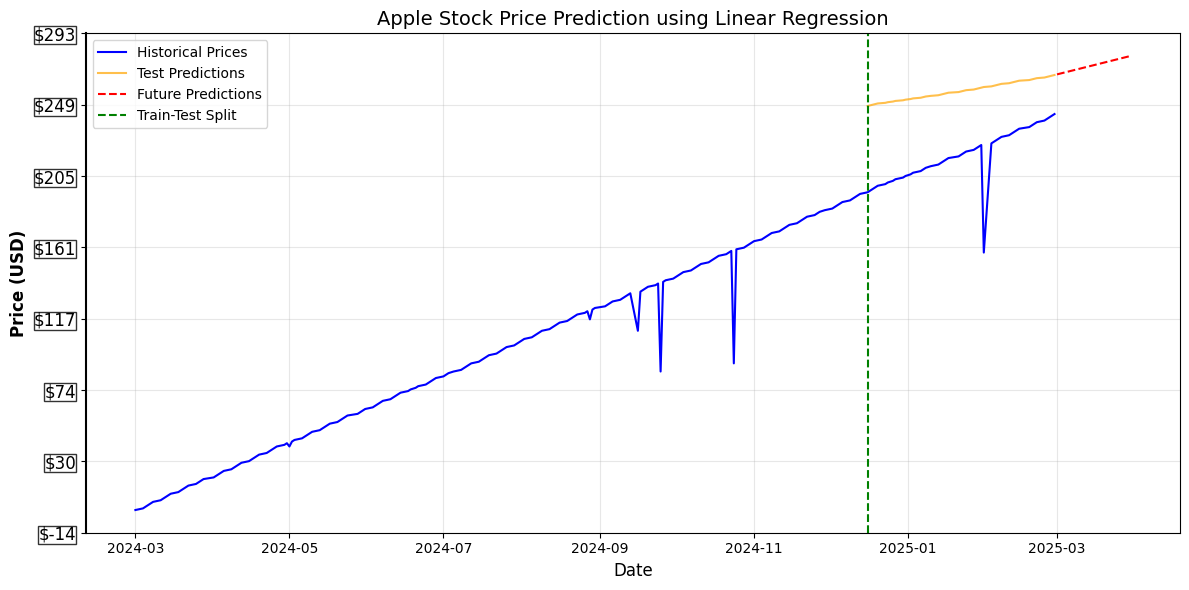

Model performance metrics:
RMSE: $21.53
R² Score: -4.0022

Future price predictions:
                           Predicted_Price
2025-03-01 00:00:00+00:00       267.350895
2025-03-02 00:00:00+00:00       267.738918
2025-03-03 00:00:00+00:00       268.126941
2025-03-04 00:00:00+00:00       268.514964
2025-03-05 00:00:00+00:00       268.902987


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import FuncFormatter


df = pd.read_csv('apple_stock_1year_1h.csv')


df['Datetime'] = pd.to_datetime(df['Datetime'])


df = df.set_index('Datetime')

daily_data = df['Close'].resample('D').last().dropna()


forecast_df = pd.DataFrame()
forecast_df['Price'] = daily_data
forecast_df['Day'] = range(1, len(daily_data) + 1)  

X = forecast_df[['Day']].values
y = forecast_df['Price'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


future_days = np.array(range(len(forecast_df) + 1, len(forecast_df) + 31)).reshape(-1, 1)
future_prices = model.predict(future_days)


last_date = forecast_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({
    'Predicted_Price': future_prices
}, index=future_dates)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)


fig, ax = plt.subplots(figsize=(12, 6))


plt.subplots_adjust(left=0.15)


ax.plot(forecast_df.index, forecast_df['Price'], label='Historical Prices', color='blue')


test_dates = forecast_df.index[-len(y_test):]
ax.plot(test_dates, y_pred, label='Test Predictions', color='orange', alpha=0.7)


ax.plot(future_df.index, future_df['Predicted_Price'], label='Future Predictions', 
         color='red', linestyle='--')


ax.axvline(x=test_dates[0], color='green', linestyle='--', label='Train-Test Split')


def dollar_format(x, pos):
    return '${:,.0f}'.format(x)

ax.yaxis.set_major_formatter(FuncFormatter(dollar_format))


y_min, y_max = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(y_min, y_max, 8))


ax.tick_params(axis='y', labelsize=12)
for label in ax.get_yticklabels():
    label.set_bbox(dict(facecolor='white', edgecolor=None, alpha=0.8, pad=0))


ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('black')


ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD)', fontsize=12, fontweight='bold')
ax.set_title('Apple Stock Price Prediction using Linear Regression', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Model performance metrics:")
print(f"RMSE: ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print("\nFuture price predictions:")
print(future_df.head())


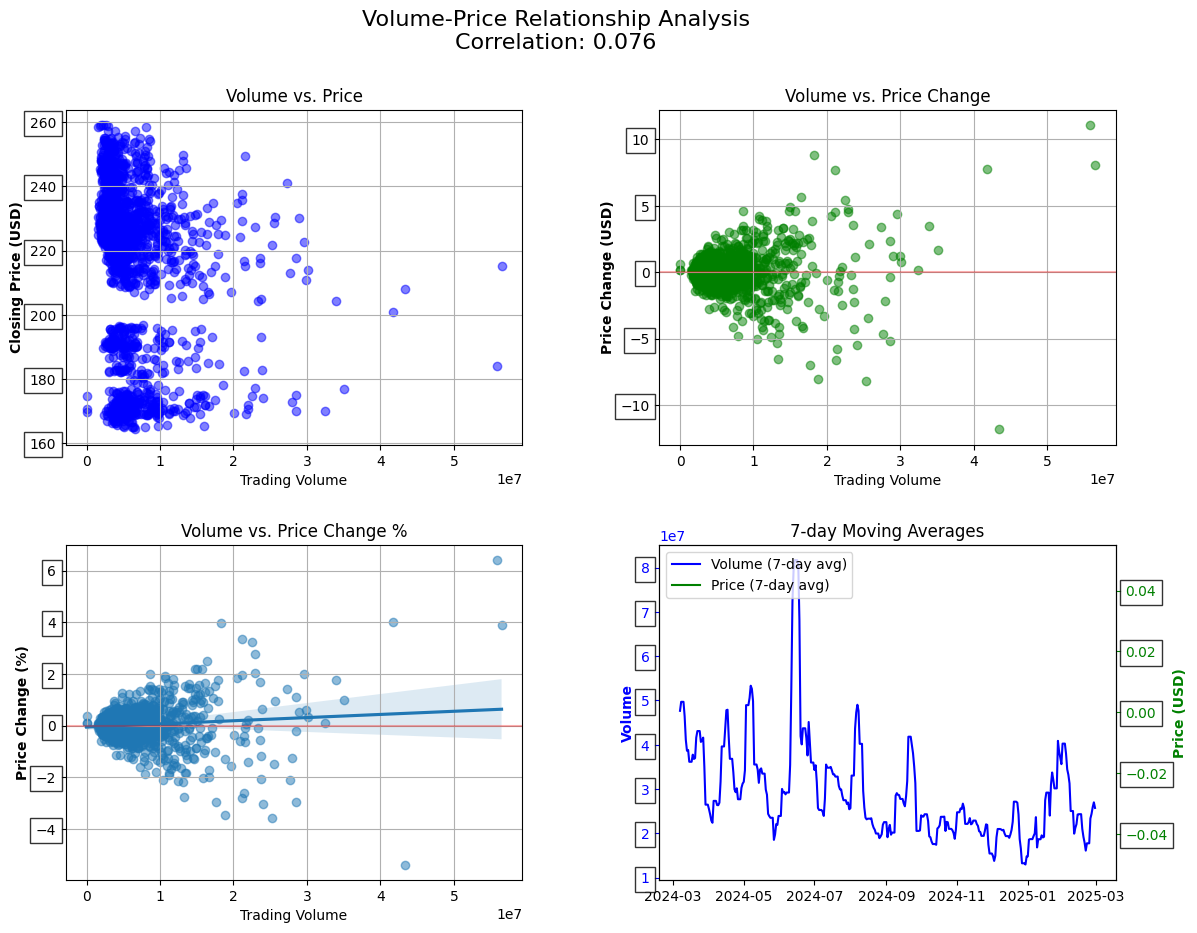

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('apple_stock_1year_1h.csv')


df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')


df['Price_Change'] = df['Close'].diff()


df = df.dropna()


fig, axes = plt.subplots(2, 2, figsize=(14, 10))


plt.subplots_adjust(left=0.15, wspace=0.3, hspace=0.3)


axes[0, 0].scatter(df['Volume'], df['Close'], alpha=0.5, color='blue')
axes[0, 0].set_title('Volume vs. Price')
axes[0, 0].set_xlabel('Trading Volume')
axes[0, 0].set_ylabel('Closing Price (USD)', fontweight='bold')
axes[0, 0].grid(True)


axes[0, 1].scatter(df['Volume'], df['Price_Change'], alpha=0.5, color='green')
axes[0, 1].set_title('Volume vs. Price Change')
axes[0, 1].set_xlabel('Trading Volume')
axes[0, 1].set_ylabel('Price Change (USD)', fontweight='bold')
axes[0, 1].axhline(y=0, color='red', linestyle='-', alpha=0.3)
axes[0, 1].grid(True)


df['Price_Change_Pct'] = df['Close'].pct_change() * 100
sns.regplot(x='Volume', y='Price_Change_Pct', data=df, ax=axes[1, 0], 
            scatter_kws={'alpha': 0.5})
axes[1, 0].set_title('Volume vs. Price Change %')
axes[1, 0].set_xlabel('Trading Volume')
axes[1, 0].set_ylabel('Price Change (%)', fontweight='bold')
axes[1, 0].axhline(y=0, color='red', linestyle='-', alpha=0.3)
axes[1, 0].grid(True)

daily_data = df.resample('D', on='Datetime').agg({
    'Close': 'last',
    'Volume': 'sum'
})


volume_ma = daily_data['Volume'].rolling(window=7).mean()
price_ma = daily_data['Close'].rolling(window=7).mean()


ax4 = axes[1, 1]
ax4_twin = ax4.twinx()  


ax4.plot(daily_data.index, volume_ma, color='blue', label='Volume (7-day avg)')
ax4_twin.plot(daily_data.index, price_ma, color='green', label='Price (7-day avg)')


ax4.set_ylabel('Volume', color='blue', fontweight='bold')
ax4_twin.set_ylabel('Price (USD)', color='green', fontweight='bold')
ax4.tick_params(axis='y', colors='blue')
ax4_twin.tick_params(axis='y', colors='green')
ax4.set_title('7-day Moving Averages')


for ax in fig.get_axes():
    for label in ax.get_yticklabels():
        label.set_bbox(dict(facecolor='white', alpha=0.8))


lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


correlation = df['Volume'].corr(df['Price_Change'])
plt.suptitle(f'Volume-Price Relationship Analysis\nCorrelation: {correlation:.3f}', 
             fontsize=16)

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('apple_stock_1year_1h.csv', skiprows=1)

price_column = df.columns[4] if len(df.columns) >= 5 else df.columns[1]


df['Datetime'] = pd.to_datetime(df[date_column], errors='coerce')
df['Price'] = pd.to_numeric(df[price_column], errors='coerce')
df = df.dropna(subset=['Datetime', 'Price'])


df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek  

plt.figure(figsize=(14, 6))
plt.subplots_adjust(left=0.15)  


plt.subplot(1, 2, 1)
hour_data = df.groupby('Hour')['Price'].mean()
plt.bar(hour_data.index, hour_data.values, color='skyblue')
plt.title('Average Price by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Price (USD)', fontweight='bold')
plt.grid(True, axis='y')

plt.subplot(1, 2, 2)
day_data = df.groupby('DayOfWeek')['Price'].mean()
available_days = sorted(df['DayOfWeek'].unique())
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_labels = [days[i] for i in available_days]

plt.bar(range(len(available_days)), day_data.values, color='coral')
plt.title('Average Price by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Price (USD)', fontweight='bold')
plt.xticks(range(len(available_days)), day_labels, rotation=45)
plt.grid(True, axis='y')


for ax in plt.gcf().get_axes():
    for label in ax.get_yticklabels():
        label.set_bbox(dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


print("\nKey Findings:")
print(f"Hour with highest price: {hour_data.idxmax()} (${hour_data.max():.2f})")
print(f"Day with highest price: {days[day_data.idxmax()]} (${day_data.max():.2f})")
